Classical (or manual) way of comparing models
=============================================

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,norm 
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, power_transform
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
%matplotlib inline

We will work with the Diabetes dataset that comes with scikit-learn by default.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes().data, load_diabetes().target

In [4]:
X.shape # (442, 10)
y.shape # (442,)

(442,)

It is a preprocessed dataset, so there is no need to do extensive data exploration and cleaning.

As you see below, the target variable is 'almost' normal.

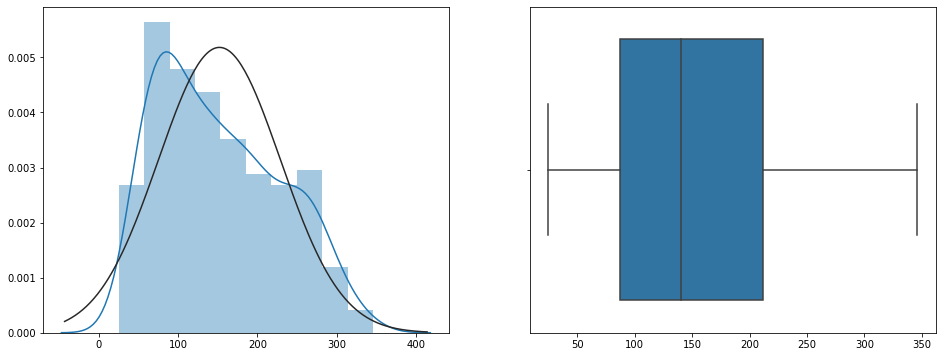

In [5]:
f,ax = plt.subplots(1, 2, figsize=(16,6))
sns.distplot(y, fit=norm,ax=ax[0])
sns.boxplot(y)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 18)

Let's say, we're starting with 5 models:
* Linear Regression
* Ridge Regression
* Stochastic Gradient Descent Regressor
* Decision Tree Regressor
* Random Forest Regressor

In [6]:
lr = LinearRegression()
ridge = Ridge()
st_gd = SGDRegressor()
des_tree = DecisionTreeRegressor()
rand_f = RandomForestRegressor()

In [7]:
all_models = [lr, ridge, st_gd, des_tree, rand_f]

In [8]:
models_dict = {0: 'Linear Regression', 1: 'Ridge Regression',\
              2: 'Stochastic Gradient Descent', 3: 'Decision Tree',\
              4: 'Random Forest'}

We can use them with default parameters, compare the performance, and choose the best

In [ ]:
# Fit the models one by one
fitted_models = []
for model in all_models:
    model.fit(X_train, y_train)
    fitted_models += [model]

In [14]:
# Collect models' mean squared errors
models_mean_sq_errors = []
for fitted_model in fitted_models:
    models_mean_sq_errors.append(mean_squared_error(y_test, fitted_model.predict(X_test)))

In [16]:
# Show the best model
print(f'{models_dict[models_mean_sq_errors.index(min(models_mean_sq_errors))]} is the model with the smallest mean squared error')
models_mean_sq_errors

Linear Regression is the model with the smallest mean_squared_error


[3006.0733911079724,
 3805.241749932629,
 3965.5215148311017,
 7326.522522522522,
 4012.7486774774775]

Let's look at a mean squared error if we just predict an average value everywhere

In [23]:
base_result = [np.mean(y_train)] * len(y_test)

In [24]:
mean_squared_error(y_test, base_result)

6103.825967943647

Our models are already performing better but there should be room for improvement

We perform Grid Search to find the best parameters 

In [18]:
models_gs = {'regression': LinearRegression(),\
             'ridge': Ridge(),\
             'Stochastic_Descent': SGDRegressor(),\
             'Decision_Tree': DecisionTreeRegressor(),\
             'Random_Forest': RandomForestRegressor()}

params_gs = {'regression': {},\
             'ridge': [{'alpha': [0.01, 0.05, 0.1, 0.3, 0.6]}],\
             'Stochastic_Descent': [{'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.00005, 0.0001, 0.0003, 0.0006, 0.001]}],\
             'Decision_Tree': [{'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3], 'max_features': ['auto', 'sqrt', 'log2']}],\
             'Random_Forest': [{'n_estimators': [100, 150, 200, 250], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3], 'max_features': ['auto', 'sqrt', 'log2']}]}

Oops, it seems that we cannot do anything with these two dictionaries. Neither GridSearchCV() nor FeatureUnion() allow to run grid search for several models.
We'll have to run searches one by one

In [41]:
lr_gs = GridSearchCV(LinearRegression(), param_grid = {}, scoring = 'neg_mean_squared_error')
ridge_gs = GridSearchCV(Ridge(), param_grid = [{'alpha': [0.01, 0.05, 0.1, 0.3, 0.6]}], scoring = 'neg_mean_squared_error')
st_gd_gs = GridSearchCV(SGDRegressor(), param_grid = [{'penalty': ['l1', 'l2', 'elasticnet'], 'alpha': [0.00005, 0.0001, 0.0003, 0.0006, 0.001], 'max_iter': [5000, 6000, 7000, 8000]}], scoring = 'neg_mean_squared_error')
des_tree_gs = GridSearchCV(DecisionTreeRegressor(), param_grid = {'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3], 'max_features': ['auto', 'sqrt', 'log2']}, scoring = 'neg_mean_squared_error')
rand_f_gs = GridSearchCV(RandomForestRegressor(), param_grid = {'n_estimators': [100, 150, 200, 250], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3], 'max_features': ['auto', 'sqrt', 'log2']}, scoring = 'neg_mean_squared_error')

In [ ]:
lr_gs.fit(X_train, y_train)
ridge_gs.fit(X_train, y_train)
st_gd_gs.fit(X_train, y_train)
des_tree_gs.fit(X_train, y_train)
rand_f_gs.fit(X_train, y_train)

In [44]:
fitted_models_gs = [lr_gs, ridge_gs, st_gd_gs, des_tree_gs, rand_f_gs]
for k, v in enumerate(fitted_models_gs):
    print(f'Best parameters of the {models_dict[k]} model are {v.best_params_}')

Best parameters of the Linear Regression model are {}
Best parameters of the Ridge Regression model are {'alpha': 0.01}
Best parameters of the Stochastic Gradient Descent model are {'alpha': 0.0001, 'max_iter': 5000, 'penalty': 'l1'}
Best parameters of the Decision Tree model are {'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 3}
Best parameters of the Random Forest model are {'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 150}


In [45]:
# Running models on the test set:
models_mean_sq_errors_gs = []
for fitted_model_gs in fitted_models_gs:
    models_mean_sq_errors_gs.append(mean_squared_error(y_test, fitted_model_gs.best_estimator_.predict(X_test)))

In [47]:
print(f'{models_dict[models_mean_sq_errors_gs.index(min(models_mean_sq_errors_gs))]} is the model with the smallest mean squared error using the best parameters')
models_mean_sq_errors_gs

Linear Regression is the model with the smallest mean squared error using the best parameters


[3006.0733911079724,
 3019.4609723576123,
 3290.5872071565755,
 5893.184039039039,
 3896.9333874693502]

In [51]:
mean_sq_errors_difference = [(aft - bef)/bef for bef, aft in zip(models_mean_sq_errors, models_mean_sq_errors_gs)]
for k, v in models_dict.items():
    print(f'After using the optimal parameters, the mean squared error of the model {v} decreased by {-mean_sq_errors_difference[k]:.2%}')

After using the optimal parameters, the mean squared error of the model Linear Regression decreased by -0.00%
After using the optimal parameters, the mean squared error of the model Ridge Regression decreased by 20.65%
After using the optimal parameters, the mean squared error of the model Stochastic Gradient Descent decreased by 17.02%
After using the optimal parameters, the mean squared error of the model Decision Tree decreased by 19.56%
After using the optimal parameters, the mean squared error of the model Random Forest decreased by 2.89%


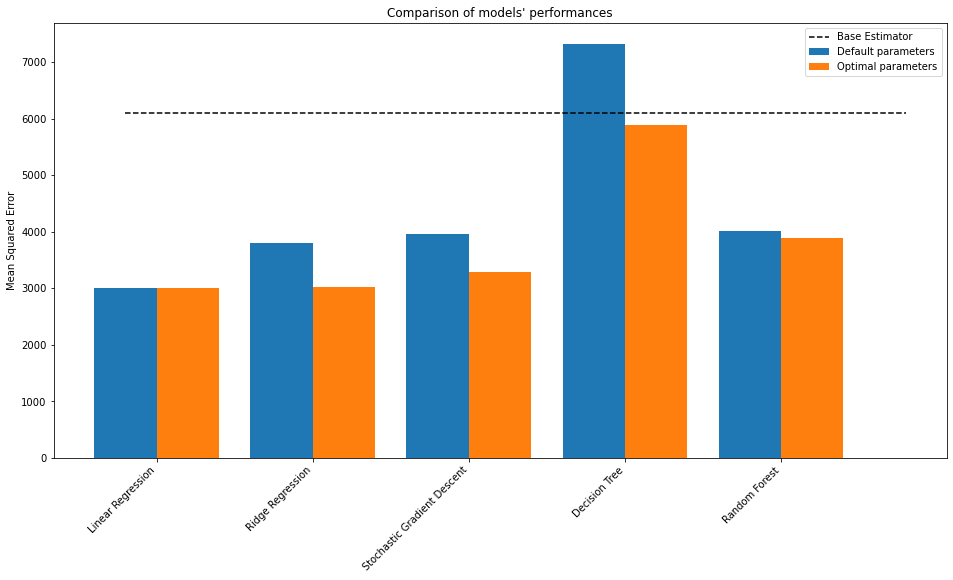

In [99]:
plt.figure(figsize=(16,8))
ind = np.arange(len(models_mean_sq_errors))
plt.bar(ind, models_mean_sq_errors, label = 'Default parameters', width = 0.4)
plt.bar(ind + 0.4, models_mean_sq_errors_gs, label = 'Optimal parameters', width = 0.4)
plt.hlines(mean_squared_error(y_test, base_result), xmin = 0, xmax = len(ind), linestyles = 'dashed', label = 'Base Estimator')


plt.ylabel('Mean Squared Error')
plt.title("Comparison of models' performances")

plt.xticks(ind + 0.2, [v for v in models_dict.values()], rotation = 45, horizontalalignment = 'right')

plt.legend()
plt.show()